# Logistic Regression

In [1]:
!pip install imblearn

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## UDF

In [24]:
def calc_vif(X):
    '''
    Calculates the variance inflation factor (VIF) for each feature.
    VIF is used to detect multicolinearity.
    '''
    vif = pd.DataFrame()
    vif['features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

## Import Dataset

In [3]:
accidents = pd.read_csv('data/accidents.csv')

In [4]:
accidents.head()

,Unnamed: 0,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,time_of_day,is_weekend,has_snow_ice,involved_pedest_cycle,at_intersection,at_stop_sign_or_traffic_light,is_day,is_evening,is_morning,is_night
0,0,JC343143,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,ONE-WAY,...,day,0,0,0,0,0,1,0,0,0
1,1,JC194776,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,...,night,0,0,0,0,1,0,0,0,1
2,2,JB200478,03/26/2018 02:23:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,...,day,0,0,0,0,0,1,0,0,0
3,3,JB415436,08/30/2018 05:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,...,day,0,0,0,0,1,1,0,0,0
4,4,JC301403,06/11/2019 08:40:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,...,morning,0,0,0,0,1,0,0,1,0


## Process Data for Model

In [5]:
predictors = ['involved_pedest_cycle',
             'is_night',
             'at_intersection',
             'has_snow_ice']


X = accidents[predictors]
y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [10]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=3)
#oversampler = SMOTE(sampling_strategy=0.5, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train_scaled, y_train)

### Hyperparameter Tuning

In [13]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values =  [0.01, 0.1, 1.0, 10, 100]
params_grid = dict(solver=solvers, C=c_values)

In [14]:
log_reg = LogisticRegression(max_iter=1000, fit_intercept=True, random_state=3)

clf = GridSearchCV(log_reg, params_grid, cv=5, verbose=0, scoring='precision')

best_model = clf.fit(X_over, y_over)

In [15]:
print('Best Solver: ', best_model.best_estimator_.get_params()['solver'])
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best Solver:  newton-cg
Best C:  0.01


### Train and Predict

In [17]:
solver='newton-cg'
c=0.01

log_reg = LogisticRegression(solver=solver, C=c, max_iter=1000, fit_intercept=True, random_state=3)
log_reg.fit(X_over, y_over)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[57186   364]
 [ 1047    18]]


Recall (Scores FN):  0.0169
Precision (Scores FP):  0.0471
AUC Score:  0.5551


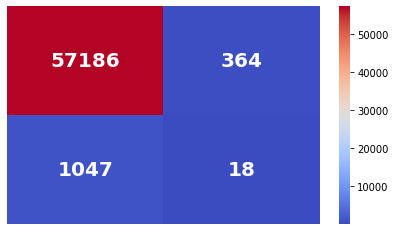

In [18]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

In [19]:
coef_summary = pd.DataFrame()
coef_summary['feature_name'] = pd.Series(X.columns)
coef_summary['log_reg_coef'] = pd.Series(log_reg.coef_[0])
coef_summary.sort_values('log_reg_coef', inplace = True, ascending=False)
coef_summary

,feature_name,log_reg_coef
2,at_intersection,0.709860
1,is_night,0.413015
0,involved_pedest_cycle,0.000000
3,has_snow_ice,-0.440705


In [20]:
print('Intercept: ', log_reg.intercept_[0])

Intercept:  -0.7858600267437933


### Test for Multicolinearity

In [23]:
X_over = sm.add_constant(X_over)
model = sm.Logit(y_over, X_over)
results = model.fit(method='bfgs')
results.summary()

Optimization terminated successfully.
         Current function value: 0.629848
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      is_fatal_or_incap   No. Observations:               345027
Model:                          Logit   Df Residuals:                   345023
Method:                           MLE   Df Model:                            3
Date:                Sun, 31 Jan 2021   Pseudo R-squ.:                 0.01047
Time:                        18:04:39   Log-Likelihood:            -2.1731e+05
converged:                       True   LL-Null:                   -2.1961e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7869      0.004   -187.078      0.000      -0.795      -0.779
x1                  0   1.25e+06          0      1.000   -2.46e+06    2.46e+06
x2             0.4165      0.009     45.611      0.000       0.399       0.434
x3             0.7295      0.017     43.516      0.000       0.697       0.762
x4            -0.4564      0.019    -24.437      0.000      -0.493      -0.420
==============================================================================
"""

In [22]:
y_over

0         0
1         0
2         0
3         0
4         0
         ..
345022    1
345023    1
345024    1
345025    1
345026    1
Name: is_fatal_or_incap, Length: 345027, dtype: int64

In [27]:
X_over_df = pd.DataFrame(X_over, columns=X.columns)
utils.calc_vif(X_train_scaled_df)

ValueError: Shape of passed values is (345027, 5), indices imply (345027, 4)

In [28]:
X_over.shape

(345027, 5)